In [1]:
#!pip install --user tf-agents==0.5.0
#!pip install --user tensorflow==2.2.0

!pip install tf-agents-nightly


     |████████████████████████████████| 1.1MB 4.6MB/s 
     |████████████████████████████████| 4.8MB 684kB/s 


In [2]:
!pip list -v

Package                       Version            Location                               Installer
----------------------------- ------------------ -------------------------------------- ---------
absl-py                       0.9.0              /usr/local/lib/python3.6/dist-packages pip      
alabaster                     0.7.12             /usr/local/lib/python3.6/dist-packages pip      
albumentations                0.1.12             /usr/local/lib/python3.6/dist-packages pip      
altair                        4.1.0              /usr/local/lib/python3.6/dist-packages pip      
argon2-cffi                   20.1.0             /usr/local/lib/python3.6/dist-packages pip      
asgiref                       3.2.10             /usr/local/lib/python3.6/dist-packages pip      
astor                         0.8.1              /usr/local/lib/python3.6/dist-packages pip      
astropy                       4.0.1.post1        /usr/local/lib/python3.6/dist-packages pip      
astunparse          

In [3]:
import tensorflow as tf
tf.test.gpu_device_name()
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=ff4cd29927b1eca8ab1f5e0fe00258be0e215af8b9ae193fb7c8cec76c8eaecd
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.2 GB  | Proc size: 1.0 GB
GPU RAM Free: 14852MB | Used: 227MB | Util   2% | Total 15079MB


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np
import random

import base64
import IPython
import matplotlib
import matplotlib.pyplot as plt
import tempfile
import zipfile
import tensorflow_probability as tfp

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import policy_step as ps
from tf_agents.networks import actor_distribution_network
from tf_agents.networks import value_network
from tf_agents.networks import network
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.distributions.utils import SquashToSpecNormal
from tf_agents.networks import normal_projection_network
from tf_agents.policies import random_tf_policy
from tf_agents.policies import policy_saver
from tf_agents.specs import tensor_spec
from tf_agents.agents.sac import tanh_normal_projection_network

from tf_agents.agents.ddpg import critic_network
from tf_agents.agents.sac import sac_agent
from tf_agents.agents.ppo import ppo_clip_agent


tf.compat.v1.enable_v2_behavior()

import os
import shutil

try:
  from google.colab import files
except ImportError:
  files = None


from google.colab import drive 
drive.mount('/content/gdrive') 

tempdir = os.getenv("TEST_TMPDIR", tempfile.gettempdir())


%xmode Verbose

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Exception reporting mode: Verbose


In [3]:
# use "num_iterations = 1e6" for better results,
# 1e5 is just so this doesn't take too long. 
num_iterations =  100# @param {type:"integer"}

initial_collect_steps = 10000 # @param {type:"integer"} 
collect_steps_per_iteration = 1 # @param {type:"integer"}
replay_buffer_capacity = 1000000 # @param {type:"integer"}

batch_size = 100 # @param {type:"integer"}

critic_learning_rate = 3e-4 # @param {type:"number"}
actor_learning_rate = 3e-4 # @param {type:"number"}
alpha_learning_rate = 3e-4 # @param {type:"number"}
target_update_tau = 0.005 # @param {type:"number"}
target_update_period = 1 # @param {type:"number"}
gamma = 0.99 # @param {type:"number"}
reward_scale_factor = 1.0 # @param {type:"number"}
gradient_clipping = None # @param

actor_fc_layer_params = (100, 100, 100)
critic_joint_fc_layer_params = (100, 100, 100)

log_interval =  1000# @param {type:"integer"}

num_eval_episodes =  10# @param {type:"integer"}
eval_interval = 10 # @param {type:"integer"}

eval_returns_amt = 100 # @param {type:"integer"}



collect_episodes_per_iteration = 10 # @param {type:"integer"}
fc_layer_params = (256,256,256)
learning_rate = 1e-3 # @param {type:"number"}
log_interval = 10 # @param {type:"integer"}
num_epochs = 10

In [4]:
myrho = "000" # @param {type:"string"}
extension = "ppo-pgg-1" # @param {type:"string"}
_RHO = np.radians(int(myrho)) 
fname = "svo-" + myrho + "-" + extension

import sys
sys.path.append('/content/gdrive/My Drive/colab+git')
import pgg_add as pgg



def angular_reward(rho):
  return (lambda x, y: np.cos(rho) * x + np.sin(rho) * y)
def reward_fun(self, other):
  f = angular_reward(_RHO)
  return f(self, other)

pgg.reward_fun = reward_fun


def create_zip_file(dirname, base_filename):
  return shutil.make_archive(base_filename, 'zip', dirname)

def upload_and_unzip_file_to(dirname):
  if files is None:
    return
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    shutil.rmtree(dirname)
    zip_files = zipfile.ZipFile(io.BytesIO(uploaded[fn]), 'r')
    zip_files.extractall(dirname)
    zip_files.close()

reward_fun(70, 70)


70.0

In [5]:

def construct_agent(observation_spec, action_spec, time_step_spec):
  agent_array_action_spec = action_spec
  agent_array_observation_spec = observation_spec

  agent_action_spec = tensor_spec.from_spec(agent_array_action_spec)
  agent_observation_spec = tensor_spec.from_spec(agent_array_observation_spec)


  critic_net = critic_network.CriticNetwork(
    (agent_observation_spec, agent_action_spec),
    observation_fc_layer_params=None,
    action_fc_layer_params=None,
    joint_fc_layer_params=critic_joint_fc_layer_params)


  actor_net = actor_distribution_network.ActorDistributionNetwork(
    agent_observation_spec,
    agent_action_spec,
    fc_layer_params=actor_fc_layer_params,
    continuous_projection_net=tanh_normal_projection_network
        .TanhNormalProjectionNetwork
    )

  value_net = value_network.ValueNetwork(observation_spec)

  global_step = tf.compat.v1.train.get_or_create_global_step()

  tf_agent = sac_agent.SacAgent(
      time_step_spec,
      agent_action_spec,
      actor_network=actor_net,
      critic_network=critic_net,
      actor_optimizer=tf.compat.v1.train.AdamOptimizer(
          learning_rate=actor_learning_rate),
      critic_optimizer=tf.compat.v1.train.AdamOptimizer(
          learning_rate=critic_learning_rate),
      alpha_optimizer=tf.compat.v1.train.AdamOptimizer(
          learning_rate=alpha_learning_rate),
      target_update_tau=target_update_tau,
      target_update_period=target_update_period,
      td_errors_loss_fn=tf.compat.v1.losses.mean_squared_error,
      gamma=gamma,
      reward_scale_factor=reward_scale_factor,
      gradient_clipping=gradient_clipping,
      train_step_counter=global_step)
  tf_agent.initialize()
  return tf_agent

def construct_ppo_agent(observation_spec, action_spec, time_step_spec):
  agent_array_action_spec = action_spec
  agent_array_observation_spec = observation_spec

  agent_action_spec = tensor_spec.from_spec(agent_array_action_spec)
  agent_observation_spec = tensor_spec.from_spec(agent_array_observation_spec)

  actor_net = actor_distribution_network.ActorDistributionNetwork(
    agent_observation_spec,
    agent_action_spec,
    fc_layer_params=fc_layer_params)


  optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
  value_net = value_network.ValueNetwork(agent_observation_spec)

  global_step = tf.compat.v1.train.get_or_create_global_step()

  tf_agent = ppo_clip_agent.PPOClipAgent(
          time_step_spec,
          agent_action_spec,
          optimizer,
          actor_net=actor_net,
          value_net=value_net,
          entropy_regularization=0.0,
          importance_ratio_clipping=0.5,
          normalize_observations=True,
          normalize_rewards=True,
          use_gae=True,
          num_epochs=num_epochs,
          debug_summaries=False,
          summarize_grads_and_vars=True,
          train_step_counter=global_step)

  tf_agent.initialize()

  return tf_agent


In [6]:


def create_env():
  return tf_py_environment.TFPyEnvironment(pgg.PublicGoodsEnv())

def validate_random(environment, episodes):
  time_step_spec = environment.time_step_spec()
  action_spec = environment.action_spec()

  episode_count = 0
  time_step = environment.reset()

  while episode_count < episodes:
    if not array_spec.check_arrays_nest(time_step, time_step_spec):
      raise ValueError(
          'Given `time_step`: %r does not match expected `time_step_spec`: %r' %
          (time_step, time_step_spec))
    obs = time_step.observation
    action0 = [random.uniform(0, 1)]
    action1 = [random.uniform(0, 1)]

    new_action = [action0[0], action1[0]]
    time_step = environment.step(new_action)
    print(time_step)

    if time_step.is_last():
        episode_count += 1
        time_step = environment.reset()

#validate_random(pgg.PublicGoodsEnv(), 5)

In [7]:
def make_checkpoint(tf_agent, train_env, checkpoint_dir, replay_buffer):
  train_checkpointer = common.Checkpointer(
      ckpt_dir=checkpoint_dir,
      max_to_keep=1,
      agent=tf_agent,
      policy=tf_agent.policy,
      replay_buffer=replay_buffer,
      global_step=tf_agent.train_step_counter
  )

  return train_checkpointer

#need to replace train_checkpointer

In [8]:
def self_play_train(tf_agent, train_env, eval_env, train_checkpointer, replay_buffer):
  """GPUs = GPU.getGPUs()
  gpu = GPUs[0]
  def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
  printm()"""
  def construct_intended_action(policy0, policy1, time_step):
    return pgg.construct_intended_action(policy0, policy1, time_step)
  
  def compute_avg_return(environment, policy0, policy1, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):

      time_step = environment.reset()
      episode_return = 0.0

      while not time_step.is_last():
        new_action = construct_intended_action(policy0, policy1, time_step, False)
        action_step = ps.PolicyStep(action=new_action)

        time_step = environment.step(action_step.action)
        
        episode_return += time_step.reward
      total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]


  """rb_checkpointer = common.Checkpointer(
        ckpt_dir=os.path.join(tempdir, 'replay_buffer'),
        max_to_keep=1,
        replay_buffer=replay_buffer)"""
  
  """upload_and_unzip_file_to(os.path.join(tempdir, 'replay_buffer'))
  rb_checkpointer.initialize_or_restore()"""
  
  def collect_step(environment, policy0, policy1):

    time_step = environment.current_time_step()

    new_action = construct_intended_action(policy0, policy1, time_step, False)

    action_step = ps.PolicyStep(action=new_action)


    next_time_step = environment.step(action_step.action)

    traj = trajectory.from_transition(time_step, action_step, next_time_step) #expand 

    # Add trajectory to the replay buffer
    replay_buffer.add_batch(traj)

  def collect_data(env, policy0, policy1, steps):
    for _ in range(steps):
      collect_step(env, policy0, policy1)

  collect_data(train_env, tf_agent.collect_policy, tf_agent.collect_policy, steps=100)

  # Dataset generates trajectories with shape [Bx2x...]
  dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

  iterator = iter(dataset)

  
  with tf.device('/device:GPU:0'):
    try:
      %%time
    except:
      pass



    # (Optional) Optimize by wrapping some of the code in a graph using TF function.
    tf_agent.train = common.function(tf_agent.train)

    # Reset the train step
    tf_agent.train_step_counter.assign(0)

    # Evaluate the agent's policy once before training.
    avg_return = compute_avg_return(eval_env, tf_agent.policy, tf_agent.policy, num_eval_episodes)
    returns = [avg_return]

    for _ in range(num_iterations):
      """printm()
      print("CPU usage: {}".format(psutil.cpu_percent()))
      GPU.showUtilization()"""
      # Collect a few steps using collect_policy and save to the replay buffer.
      for _ in range(collect_steps_per_iteration):
        collect_step(train_env, tf_agent.collect_policy, tf_agent.collect_policy)

      # Sample a batch of data from the buffer and update the agent's network.

      experience, unused_info = next(iterator)
      train_loss = tf_agent.train(experience)

      step = tf_agent.train_step_counter.numpy()

      if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss.loss))

      if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, tf_agent.policy, tf_agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)


    steps = range(0, num_iterations + 1, eval_interval)
    plt.plot(steps, returns)
    plt.ylabel('Average Return')
    plt.xlabel('Step')
    plt.ylim(top=20)

    train_checkpointer.save(tf_agent.train_step_counter.numpy())
    #rb_checkpointer.save(global_step)
    



In [9]:
def self_play_train_ppo(tf_agent, train_env, eval_env, train_checkpointer, replay_buffer):
  """GPUs = GPU.getGPUs()
  gpu = GPUs[0]
  def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
  printm()"""
  def construct_intended_action(policy0, policy1, time_step):
    return pgg.construct_intended_action(policy0, policy1, time_step)
  
  def compute_avg_return(environment, policy0, policy1, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):

      time_step = environment.reset()
      episode_return = 0.0

      while not time_step.is_last():
        new_action, _, _ = construct_intended_action(policy0, policy1, time_step)
        action_step = ps.PolicyStep(action=new_action)

        time_step = environment.step(action_step.action)
        
        episode_return += time_step.reward
      total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]


  """rb_checkpointer = common.Checkpointer(
        ckpt_dir=os.path.join(tempdir, 'replay_buffer'),
        max_to_keep=1,
        replay_buffer=replay_buffer)"""
  
  """upload_and_unzip_file_to(os.path.join(tempdir, 'replay_buffer'))
  rb_checkpointer.initialize_or_restore()"""
  
  def collect_episode(environment, policy0, policy1, num_episodes):

    episode_counter = 0
    environment.reset()
    while episode_counter < num_episodes:
      time_step = environment.current_time_step()

      my_action_step = policy0.action(time_step)
      new_action, state, info = construct_intended_action(policy0, policy1, time_step)
      action_step = ps.PolicyStep(action=new_action, state=state, info=info)


      next_time_step = environment.step(action_step.action)

      traj = trajectory.from_transition(time_step, my_action_step, next_time_step) #expand 

      # Add trajectory to the replay buffer
      replay_buffer.add_batch(traj)

      if traj.is_boundary():
        episode_counter += 1


  
  with tf.device('/device:GPU:0'):
    try:
      %%time
    except:
      pass

    # (Optional) Optimize by wrapping some of the code in a graph using TF function.
    tf_agent.train = common.function(tf_agent.train)

    # Reset the train step
    tf_agent.train_step_counter.assign(0)

    # Evaluate the agent's policy once before training.
    avg_return = compute_avg_return(eval_env, tf_agent.policy, tf_agent.policy, num_eval_episodes)
    returns = [avg_return]

    for _ in range(num_iterations):

      # Collect a few episodes using collect_policy and save to the replay buffer.
      collect_episode(
          train_env, tf_agent.collect_policy, tf_agent.collect_policy, collect_episodes_per_iteration)

      # Use data from the buffer and update the agent's network.
      experience = replay_buffer.gather_all()
      train_loss = tf_agent.train(experience=experience)
      replay_buffer.clear()

      step = tf_agent.train_step_counter.numpy()

      if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss.loss))

      if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, tf_agent.policy, tf_agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

    train_checkpointer.save(tf_agent.train_step_counter.numpy())


    steps = range(0, tf_agent.train_step_counter.numpy(), eval_interval)
    plt.plot(steps, returns)
    plt.ylabel('Average Return')
    plt.xlabel('Step')
    plt.ylim(top=20)

    #rb_checkpointer.save(global_step)
    



In [10]:
def get_checkpoint_name(fname):
  return "gdrive/My Drive/colab+git/"+fname+"-cp"
def save_checkpoint(fname, checkpoint_dir, train_checkpointer, rb_checkpointer):
  train_checkpointer.save(tf.compat.v1.train.get_or_create_global_step())
  checkpoint_zip_filename = create_zip_file(checkpoint_dir, os.path.join(tempdir, fname + '-cp'))
  #rb_checkpoint_zip_filename = create_zip_file(os.path.join(tempdir, 'replay_buffer'), os.path.join(tempdir, fname + '-rb'))
  %pwd
  nm = get_checkpoint_name(fname)
  os.mkdir(nm)

  shutil.move(checkpoint_zip_filename, nm)
  #shutil.move(checkpoint_zip_filename, "gdrive/My Drive/colab+git/"+fname+"-rb")




In [11]:
def unzip_cp(checkpoint_dir, fname, train_checkpointer):
  #checkpoint_dir = checkpoint_dir in fname
  train_checkpointer.save(tf_agent.train_step_counter.numpy())
  nm = get_checkpoint_name(fname)
  fl = os.path.join(nm, fname + "-cp.zip")
  print(fl)
  with zipfile.ZipFile(fl, 'r') as zip:
    k = zip.extractall(path=checkpoint_dir)
    zip.close()
  
  #print(train_checkpointer.initialize_or_restore())


In [12]:
def save_policy(tf_agent, fname):
  policy_dir = os.path.join(tempdir, 'policy')
  saver = policy_saver.PolicySaver(tf_agent.policy, batch_size=None)
  saver.save(policy_dir)

  policy_zip_filename = create_zip_file(policy_dir, os.path.join(tempdir, fname + '-p'))
  #rb_checkpoint_zip_filename = create_zip_file(os.path.join(tempdir, 'replay_buffer'), os.path.join(tempdir, fname + '-rb'))
  %pwd
  nm = get_policy_dir_name(fname)
  os.mkdir(nm)

  shutil.move(policy_zip_filename, nm)
  #shutil.move(checkpoint_zip_filename, "gdrive/My Drive/colab+git/"+fname+"-rb")

def get_policy_dir_name(fname):
  return "gdrive/My Drive/colab+git/"+fname+"-cp/p"
def get_policy_name(fname):
  dir = get_policy_dir_name(fname)
  return dir + "/" + fname + "-p.zip"


In [13]:
import pandas as pd
def construct_play_action(new_action):
  if type(new_action) is tuple:
    p, _, _ = new_action
    new_action = p
  return new_action

def play_self(policy, environment):
  ret = []
  done = False
  time_step = environment.reset()

  while not done:
    time_step = environment.current_time_step()
    #print(time_step.observation)
    #print(policy0.distribution(time_step))

    new_action = pgg.construct_intended_action(policy, policy, time_step)
    new_action = construct_play_action(new_action)
    #print(new_action)
    act = new_action.numpy()[0]
    action_step = ps.PolicyStep(action=new_action)


    next_time_step = environment.step(action_step.action)

    traj = trajectory.from_transition(time_step, action_step, next_time_step) #expand 
    if traj.is_boundary():
      done = True
      return time_step.observation.numpy()

def play_fixed_action(policy, action, environment):
  ret = []
  done = False
  time_step = environment.reset()

  while not done:
    time_step = environment.current_time_step()

    new_action = pgg.construct_fixed_action(policy, action, time_step)
    new_action = construct_play_action(new_action)

    act = new_action.numpy()[0]
    action_step = ps.PolicyStep(action=new_action)

    next_time_step = environment.step(action_step.action)

    traj = trajectory.from_transition(time_step, action_step, next_time_step) #expand 
    if traj.is_boundary():
      done = True
      return time_step.observation.numpy()

def play_tit_for_tat(policy, environment):
  ret = []
  done = False
  time_step = environment.reset()
  prev_act = 1

  while not done:
    time_step = environment.current_time_step()

    new_action = pgg.construct_fixed_action(policy, prev_act, time_step)
    new_action = construct_play_action(new_action)

    act = new_action.numpy()[0]
    prev_act = new_action[0].numpy()[0]
    action_step = ps.PolicyStep(action=new_action)

    next_time_step = environment.step(action_step.action)

    traj = trajectory.from_transition(time_step, action_step, next_time_step) #expand 
    if traj.is_boundary():
      done = True
      #print(time_step.reward)
      return time_step.observation.numpy()

def add_graph(graph, obs):
  r, c = np.shape(obs)
  for i in range(r):
    graph[i].append(obs[i][0])

def create_empty_graph():
  ret = []
  for i in range(12):
    ret.append([])
  return ret

def eval_returns(checkpoint_dir, fname, train_checkpointer, eval_env, policy):


  self_graph = create_empty_graph()
  coop_graph = create_empty_graph()
  defect_graph = create_empty_graph()
  tft_graph = create_empty_graph()
  fixed_game_returns = np.array(range(4), dtype=object)
  s1 = 0
  s2 = 0
  s3 = 0
  s4 = 0


  for _ in range(eval_returns_amt):
    self_g = play_self(policy, eval_env)[0]
    #print(self_g)
    s1 += reward_fun(self_g[11][0], self_g[11][1])
    add_graph(self_graph, self_g)

    nc = (play_fixed_action(policy, 1, eval_env))[0]
    #print(nc)
    s2 += reward_fun(nc[11][0], nc[11][1])
    add_graph(coop_graph, nc)

    nd = (play_fixed_action(policy, 0, eval_env))[0]
    #print(nd)
    s3 += reward_fun(nd[11][0], nd[11][1])
    add_graph(defect_graph, nd)

    nt = (play_tit_for_tat(policy, eval_env))[0]
    #print(nt)
    s4 += reward_fun(nt[11][0], nt[11][1])
    add_graph(tft_graph, nt)


  fixed_game_returns[0] = s1/100
  fixed_game_returns[1] = s2/100
  fixed_game_returns[2] = s3/100
  fixed_game_returns[3] = s4/100

  nm = "gdrive/My Drive/colab+git/fixed_data"
  os.mkdir(os.path.join(nm, fname))
  np.savetxt(os.path.join(nm, fname+"/fixed_game_returns.csv"), fixed_game_returns)
  print('self', 'cooperate', 'defect', 'tit-for-tat', fixed_game_returns)
  fig, axs = plt.subplots(4, sharex=True, sharey=True)


  data0 = np.transpose(np.array(self_graph))
  np.savetxt(os.path.join(nm, fname+"/self_graph.csv"), data0)
  axs[0].set_title('self')
  axs[0].boxplot(data0[:,:-1])

  data1 = np.transpose(np.array(coop_graph))
  np.savetxt(os.path.join(nm, fname+"/coop_graph.csv"), data1)
  axs[1].set_title('coop')
  axs[1].boxplot(data1[:,:-1])

  data2 = np.transpose(np.array(defect_graph))
  np.savetxt(os.path.join(nm, fname+"/defect_graph.csv"), data2)
  axs[2].set_title('defect')
  axs[2].boxplot(data2[:,:-1])

  data3 = np.transpose(np.array(tft_graph))
  np.savetxt(os.path.join(nm, fname+"/tft_graph.csv"), data3)
  axs[3].set_title('tft')
  axs[3].boxplot(data3[:,:-1])

  plt.show()

def make_graphs(dirname):
  nm = "gdrive/My Drive/colab+git/fixed_data/"+dirname
  fixed_game_returns = np.loadtxt(os.path.join(nm, "fixed_game_returns.csv"))
  self_graph = np.loadtxt(os.path.join(nm, "self_graph.csv"))
  coop_graph = np.loadtxt(os.path.join(nm, "coop_graph.csv"))
  defect_graph = np.loadtxt(os.path.join(nm, "defect_graph.csv"))
  tft_graph = np.loadtxt(os.path.join(nm, "tft_graph.csv"))
  print('self', 'cooperate', 'defect', 'tit-for-tat', fixed_game_returns)
  fig, axs = plt.subplots(4, sharex=True, sharey=True)
  axs[0].set_title('self')
  axs[0].boxplot(self_graph[:,:-1])
  axs[1].set_title('coop')
  axs[1].boxplot(coop_graph[:,:-1])
  axs[2].set_title('defect')
  axs[2].boxplot(defect_graph[:,:-1])
  axs[3].set_title('tft')
  axs[3].boxplot(tft_graph[:,:-1])




def eval_returns_no_save(checkpoint_dir, fname, train_checkpointer, eval_env, policy):


  self_graph = create_empty_graph()
  coop_graph = create_empty_graph()
  defect_graph = create_empty_graph()
  tft_graph = create_empty_graph()
  fixed_game_returns = np.array(range(4), dtype=object)
  s1 = 0
  s2 = 0
  s3 = 0
  s4 = 0


  for _ in range(1):
    self_g = play_self(policy, eval_env)[0]
    #print(self_g)
    s1 += reward_fun(self_g[11][0], self_g[11][1])
    add_graph(self_graph, self_g)

    nc = (play_fixed_action(policy, 1, eval_env))[0]
    #print(nc)
    s2 += reward_fun(nc[11][0], nc[11][1])
    add_graph(coop_graph, nc)

    nd = (play_fixed_action(policy, 0, eval_env))[0]
    #print(nd)
    s3 += reward_fun(nd[11][0], nd[11][1])
    add_graph(defect_graph, nd)

    nt = (play_tit_for_tat(policy, eval_env))[0]
    #print(nt)
    s4 += reward_fun(nt[11][0], nt[11][1])
    add_graph(tft_graph, nt)


  fixed_game_returns[0] = s1/100
  fixed_game_returns[1] = s2/100
  fixed_game_returns[2] = s3/100
  fixed_game_returns[3] = s4/100

  nm = "gdrive/My Drive/colab+git/fixed_data"
  print('self', 'cooperate', 'defect', 'tit-for-tat', fixed_game_returns)
  fig, axs = plt.subplots(4, sharex=True, sharey=True)


  data0 = np.transpose(np.array(self_graph))
  axs[0].set_title('self')
  axs[0].boxplot(data0[:,:-1])

  data1 = np.transpose(np.array(coop_graph))
  axs[1].set_title('coop')
  axs[1].boxplot(data1[:,:-1])

  data2 = np.transpose(np.array(defect_graph))
  axs[2].set_title('defect')
  axs[2].boxplot(data2[:,:-1])

  data3 = np.transpose(np.array(tft_graph))
  axs[3].set_title('tft')
  axs[3].boxplot(data3[:,:-1])

  plt.show()







In [19]:
#from python_dict_wrapper import wrap, unwrap
def extract_policy(nm):
  with zipfile.ZipFile(nm, 'r') as zip:
    zip.extractall(path=nm[:-4])
    zip.close()
    return tf.compat.v2.saved_model.load(nm[:-4])
def league(dirnames, train_checkpointer, train_env, eval_env, replay_buffer, current_train, mytype):

  def construct_intended_action(policy0, policy1, time_step):
    return pgg.construct_intended_action(policy0, policy1, time_step)
  
  def compute_avg_return(environment, policy0, policy1, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):

      time_step = environment.reset()
      episode_return = 0.0

      while not time_step.is_last():
        new_action, _, _ = construct_intended_action(policy0, policy1, time_step)
        action_step = ps.PolicyStep(action=new_action)

        time_step = environment.step(action_step.action)
        
        episode_return += time_step.reward
      total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

  def compute_avg_return_v2(environment, policy0, policy1, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):

      time_step = environment.reset()
      episode_return = 0.0

      while not time_step.is_last():
        new_action = construct_intended_action(policy0, policy1, time_step)
        action_step = ps.PolicyStep(action=new_action)

        time_step = environment.step(action_step.action)
        
        episode_return += time_step.reward
      total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

  def collect_episode(environment, policy0, policy1, num_episodes):

      episode_counter = 0
      environment.reset()
      while episode_counter < num_episodes:
        time_step = environment.current_time_step()

        my_action_step = policy0.action(time_step)

        new_action, state, info = construct_intended_action(policy0, policy1, time_step)
        action_step = ps.PolicyStep(action=new_action, state=state, info=info)


        next_time_step = environment.step(action_step.action)



        traj = trajectory.from_transition(time_step, my_action_step, next_time_step) #expand 
        #print(traj)
        # Add trajectory to the replay buffer
        replay_buffer.add_batch(traj)

        if traj.is_boundary():
          episode_counter += 1

  
  def collect_step(environment, policy0, policy1):

    time_step = environment.current_time_step()

    my_action = policy0.action(time_step)
    new_action = construct_intended_action(policy0, policy1, time_step)

    action_step = ps.PolicyStep(action=new_action)


    next_time_step = environment.step(action_step.action)

    traj = trajectory.from_transition(time_step, my_action, next_time_step) #expand 

    # Add trajectory to the replay buffer
    replay_buffer.add_batch(traj)

  def collect_data(env, policy0, policy1, steps):
    for _ in range(steps):
      collect_step(env, policy0, policy1)

  dataset = None
  iterator = None

  if mytype == "sac":
    collect_data(train_env, tf_agent.collect_policy, tf_agent.collect_policy, steps=100)

    # Dataset generates trajectories with shape [Bx2x...]
    dataset = replay_buffer.as_dataset(
      num_parallel_calls=3, 
      sample_batch_size=batch_size, 
      num_steps=2).prefetch(3)

    iterator = iter(dataset)
          
  #with tf.device('/device:GPU:0'):
  if True:
    policies = []

    for i in range(len(dirnames)):

        #os.mkdir(fnames[i][50:-4])
        
        policies.append(extract_policy(dirnames[i]))


    try:
      %%time
    except:
      pass

    # (Optional) Optimize by wrapping some of the code in a graph using TF function.
    tf_agent.train = common.function(tf_agent.train)

    # Reset the train step
    tf_agent.train_step_counter.assign(0)

    # Evaluate the agent's policy once before training.

    avg_return = None
    if mytype == "ppo":
      avg_return = compute_avg_return(eval_env, tf_agent.policy, tf_agent.policy, num_eval_episodes)
    if mytype == "sac":
      avg_return = compute_avg_return_v2(eval_env, tf_agent.policy, tf_agent.policy, num_eval_episodes)

    returns = [avg_return]

    for u in range(100):
      rand_op = random.randint(0, len(dirnames) - 1)

      print(rand_op)

      pol = None
      if rand_op == current_train:
        pol = tf_agent.collect_policy
      else:
        pol = policies[rand_op]

      for _ in range(num_iterations):

        if mytype == "ppo":
          # Collect a few episodes using collect_policy and save to the replay buffer.
          collect_episode(
              train_env, tf_agent.collect_policy, pol, collect_episodes_per_iteration)


          # Use data from the buffer and update the agent's network.
          experience = replay_buffer.gather_all()
          train_loss = tf_agent.train(experience=experience)
          replay_buffer.clear()


        if mytype == "sac":
          for _ in range(collect_steps_per_iteration):
            collect_step(train_env, tf_agent.collect_policy, tf_agent.collect_policy)

          # Sample a batch of data from the buffer and update the agent's network.

          experience, unused_info = next(iterator)
          train_loss = tf_agent.train(experience)

        step = tf_agent.train_step_counter.numpy()

        if step % log_interval == 0:
          print('step = {0}: loss = {1}'.format(step, train_loss.loss))

        if step % eval_interval == 0:
          avg_return = None
          if mytype == "ppo":
            avg_return = compute_avg_return(eval_env, tf_agent.policy, pol, num_eval_episodes)
          if mytype == "sac":
            avg_return = compute_avg_return_v2(eval_env, tf_agent.policy, pol, num_eval_episodes)

          print('step = {0}: Average Return = {1}'.format(step, avg_return))
          returns.append(avg_return)

      train_checkpointer.save(tf_agent.train_step_counter.numpy())
      steps = range(0, tf_agent.train_step_counter.numpy(), eval_interval)
      plt.plot(steps, returns[-(len(steps)):])
      plt.ylabel('Average Return')
      plt.xlabel('Step')
      plt.ylim(top=20)

  
def gpu_speed_test(dirnames, train_checkpointer, train_env, eval_env, replay_buffer, current_train):
  with tf.device('/device:GPU:0'):
    league(dirnames, train_checkpointer, train_env, eval_env, replay_buffer, current_train)

def cpu_speed_test(dirnames, train_checkpointer, train_env, eval_env, replay_buffer, current_train):
  with tf.device('/cpu:0'):
    league(dirnames, train_checkpointer, train_env, eval_env, replay_buffer, current_train)


In [15]:
checkpoint_dir = os.path.join(tempdir, fname)
env = create_env()
action_spec = array_spec.BoundedArraySpec(
    shape=(1,), dtype=np.float32, minimum=0, maximum=1, name='action')
tf_agent = construct_agent(env.observation_spec(), action_spec, env.time_step_spec())

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=env.batch_size,
    max_length=replay_buffer_capacity)
tc = make_checkpoint(tf_agent, env, checkpoint_dir, replay_buffer)



In [16]:
#unzip_cp(checkpoint_dir, fname, tc)
#nms = ['000', '045', '090', '135', '180', '225', '270', '315']
#def getnames(nms):
#  mynames = []
#  for i in range(len(nms)):
#    fn = "svo-" + nms[i] + "-1-pgg1"
#    mynames.append("gdrive/My Drive/colab+git/"+fn+"-cp/p/"+fn+"-p.zip")
#  return mynames
#dirnames = getnames(nms)
#pol = extract_policy(dirnames[3])

#eval_returns_no_save(checkpoint_dir, fname, tc, create_env(), pol)
#eval_returns_no_save(checkpoint_dir, fname, tc, create_env(), tf_agent.policy)
#make_graphs("svo-135-1-pgg1")
#league(dirnames)

In [17]:

tc = make_checkpoint(tf_agent, env, checkpoint_dir, replay_buffer)

tc._manager.latest_checkpoint

In [18]:
print(os.listdir(checkpoint_dir))
print(checkpoint_dir)

[]
/tmp/svo-000-ppo-pgg-1


In [19]:
"""checkpoint_dir = os.path.join(tempdir, fname)
env = create_env()
action_spec = array_spec.BoundedArraySpec(
    shape=(1,), dtype=np.float32, minimum=0, maximum=1, name='action')
tf_agent = construct_ppo_agent(env.observation_spec(), action_spec, env.time_step_spec())


unzip_cp(checkpoint_dir, fname, tc)
tc = make_checkpoint(tf_agent, env, checkpoint_dir, replay_buffer)
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=env.batch_size,
    max_length=replay_buffer_capacity)
print(os.listdir(checkpoint_dir))
print(tc.initialize_or_restore())
"""

"checkpoint_dir = os.path.join(tempdir, fname)\nenv = create_env()\naction_spec = array_spec.BoundedArraySpec(\n    shape=(1,), dtype=np.float32, minimum=0, maximum=1, name='action')\ntf_agent = construct_ppo_agent(env.observation_spec(), action_spec, env.time_step_spec())\n\n\nunzip_cp(checkpoint_dir, fname, tc)\ntc = make_checkpoint(tf_agent, env, checkpoint_dir, replay_buffer)\nreplay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(\n    data_spec=tf_agent.collect_data_spec,\n    batch_size=env.batch_size,\n    max_length=replay_buffer_capacity)\nprint(os.listdir(checkpoint_dir))\nprint(tc.initialize_or_restore())\n"

self cooperate defect tit-for-tat [0.29457664489746094 0.44798229217529295 0.0012863342463970183
 0.6121092224121094]


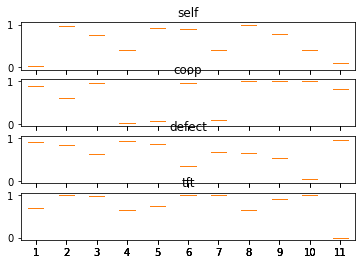

In [20]:

"""unzip_cp(checkpoint_dir, fname, tc)

checkpoint_dir = os.path.join(tempdir, fname)
env = create_env()
action_spec = array_spec.BoundedArraySpec(
    shape=(1,), dtype=np.float32, minimum=0, maximum=1, name='action')
tf_agent = construct_ppo_agent(env.observation_spec(), action_spec, env.time_step_spec())
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=env.batch_size,
    max_length=replay_buffer_capacity)"""

eval_returns_no_save(checkpoint_dir, fname, tc, create_env(), tf_agent.policy)


['gdrive/My Drive/colab+git/svo-000-ppo-pgg-1-cp/p/svo-000-ppo-pgg-1-p.zip', 'gdrive/My Drive/colab+git/svo-045-ppo-pgg-1-cp/p/svo-045-ppo-pgg-1-p.zip', 'gdrive/My Drive/colab+git/svo-090-ppo-pgg-1-cp/p/svo-090-ppo-pgg-1-p.zip', 'gdrive/My Drive/colab+git/svo-315-ppo-pgg-1-cp/p/svo-315-ppo-pgg-1-p.zip']
self cooperate defect tit-for-tat [0.38123348236083987 0.5649420928955078 0.000936439260840416
 0.14524271011352538]


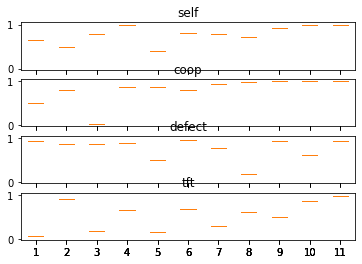

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs
3
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


step = 10: loss = 0.22162239253520966
step = 10: Average Return = -1.5090904235839844
step = 20: loss = 0.3345915973186493
step = 20: Average Return = -1.2415578365325928
step = 30: loss = 0.2176048904657364
step = 30: Average Return = -1.2760204076766968
step = 40: loss = 0.21102358400821686


In [ ]:
nms = ['000', '045', '090', '315']
def getnames(nms):
  mynames = []
  for i in range(len(nms)):
    fn = "svo-" + nms[i] + "-ppo-pgg-1"
    mynames.append("gdrive/My Drive/colab+git/"+fn+"-cp/p/"+fn+"-p.zip")
  return mynames
dirnames = getnames(nms)
print(dirnames)
eval_returns_no_save(checkpoint_dir, fname, tc, create_env(), tf_agent.policy)

league(dirnames, tc, create_env(), create_env(), replay_buffer, -1, "sac")
save_checkpoint(fname+"-scratchsac", checkpoint_dir, tc, replay_buffer)
eval_returns(checkpoint_dir, fname+"-scratchsac", tc, create_env(), tf_agent.collect_policy)
save_policy(tf_agent, fname+"-scratchsac")
pol = extract_policy(get_policy_name(fname+"-scratchsac"))
eval_returns_no_save(checkpoint_dir, fname+"-scratchsac", tc, create_env(), pol)

"""import timeit
gpu_speed_test(dirnames, tc, create_env(), create_env(), replay_buffer, 0)
cpu_speed_test(dirnames, tc, create_env(), create_env(), replay_buffer, 0)

print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit(globals=globals(), stmt='cpu_speed_test(dirnames, tc, create_env(), create_env(), replay_buffer, 0)', number=10, setup="from __main__ import cpu_speed_test")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit(globals=globals(), stmt='gpu_speed_test(dirnames, tc, create_env(), create_env(), replay_buffer, 0)', number=10, setup="from __main__ import gpu_speed_test")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))"""




INFO:tensorflow:Assets written to: /tmp/policy/assets


INFO:tensorflow:Assets written to: /tmp/policy/assets


self cooperate defect tit-for-tat [0.01 0.038732945919036865 0.01 0.0175]


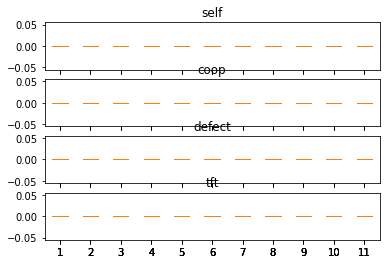

In [22]:
save_policy(tf_agent, fname+"-ontopcoopclip0v5")
pol = extract_policy(get_policy_name(fname+"-ontopcoopclip0v5"))
eval_returns_no_save(checkpoint_dir, fname+"-ontopcoopclip0v5", tc, create_env(), pol)

In [ ]:
save_checkpoint(fname+"-ontop", checkpoint_dir, tc, replay_buffer)
eval_returns(checkpoint_dir, fname+"-ontop", tc, create_env(), tf_agent.collect_policy)
save_policy(tf_agent, fname+"-ontop")
pol = extract_policy(get_policy_name(fname+"-ontop"))
eval_returns_no_save(checkpoint_dir, fname+"-ontop", tc, create_env(), pol)

In [ ]:

league()

In [ ]:
replay_buffer.get_next()


In [ ]:
#self_play_train(tf_agent, env, create_env(), tc, replay_buffer)

In [ ]:
#save_checkpoint(fname, checkpoint_dir, tc, replay_buffer)


In [ ]:
#unzip_cp(checkpoint_dir, fname, tc)

#eval_returns(checkpoint_dir, fname, tc, create_env())

In [ ]:
#make_graphs(fname)

In [ ]:

%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs

self cooperate defect tit-for-tat [1.         3.87329459 1.         1.75      ]
self cooperate defect tit-for-tat [122.32602048 122.32602048   2.76869762 122.32602048]
self cooperate defect tit-for-tat [86.49755859 86.49755859  3.87329459 86.49755859]
self cooperate defect tit-for-tat [ 1.77635684e-15  0.00000000e+00  2.32516878e+00 -8.05438818e+00]
self cooperate defect tit-for-tat [ -3.2609277  -27.56562487  -0.24790486 -11.40083243]
self cooperate defect tit-for-tat [-1.46582272 -3.04707304 -1.42189968 -2.03676046]
self cooperate defect tit-for-tat [-0.9976613  -0.02648647 -0.96821463 -0.42368796]
self cooperate defect tit-for-tat [-0.25503327  2.33327392 -0.08397719  2.1196557 ]


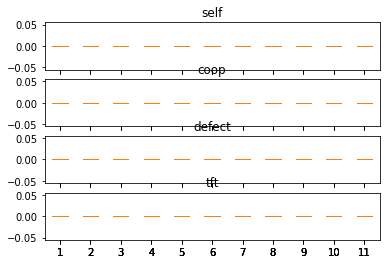

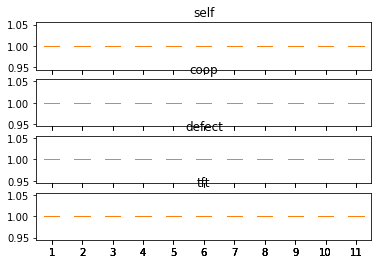

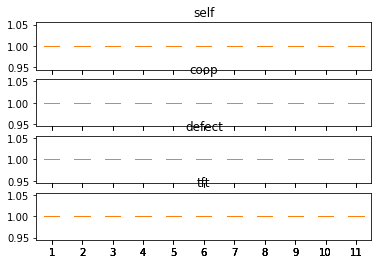

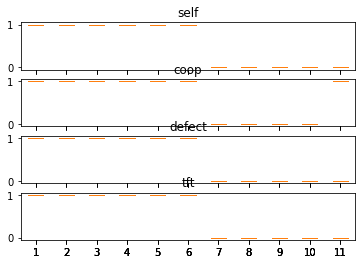

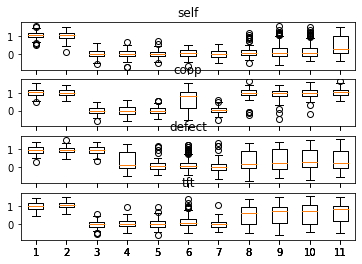

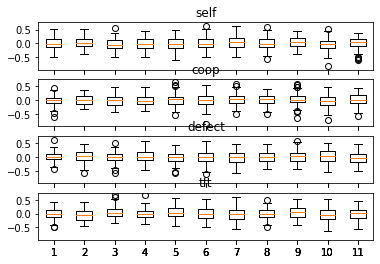

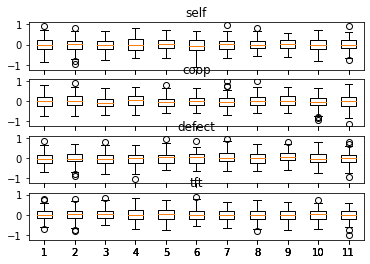

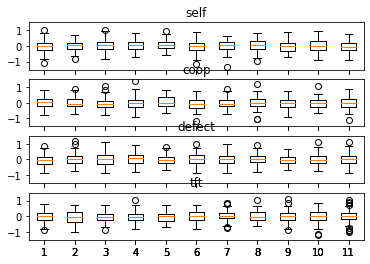

In [ ]:
make_graphs("svo-000-ppo-pgg-2")
make_graphs("svo-045-ppo-pgg-2")
make_graphs("svo-090-ppo-pgg-1")
make_graphs("svo-135-ppo-pgg-1")
make_graphs("svo-180-ppo-pgg-1")
make_graphs("svo-225-ppo-pgg-1")
make_graphs("svo-270-ppo-pgg-1")
make_graphs("svo-315-ppo-pgg-1")
